#

In [2]:
pip install tensorflow

  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4835 sha256=6bd709ecda9ce95b2bef74efb7b722923e8f22c62d7d8d9deba7ae54d36e59d5
  Stored in directory: c:\users\bommi\appdata\local\pip\cache\wheels\3f\e3\ec\8a8336ff196023622fbcb36de0c5a5c218cbb24111d1d4c7f2
  Created wheel for absl-py: filename=absl_py-0.9.0-py3-none-any.whl size=121935 sha256=def1bc83e2b4e56634d0bfa4e457120d4a52eae741618dc0e6cf22e161cc47ca
  Stored in directory: c:\users\bommi\appdata\local\pip\cache\wheels\cc\af\1a\498a24d0730ef484019e007bb9e8cef3ac00311a672c049a3e
Successfully built termcolor absl-py
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install tensorflow_hub

Note: you may need to restart the kernel to use updated packages.


This Colab demonstrates use of a TF-Hub module trained to perform object detection.

## Setup


In [5]:
#@title Imports and function definitions

# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.2.0
The following GPU devices are available: 


### Helper functions for downloading images and for visualization.

Visualization code adapted from [TF object detection API](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py) for the simplest required functionality.

In [27]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              30)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [34]:
408*2

816

Image downloaded to C:\Users\Bommi\AppData\Local\Temp\tmpu_cqauq4.jpg.


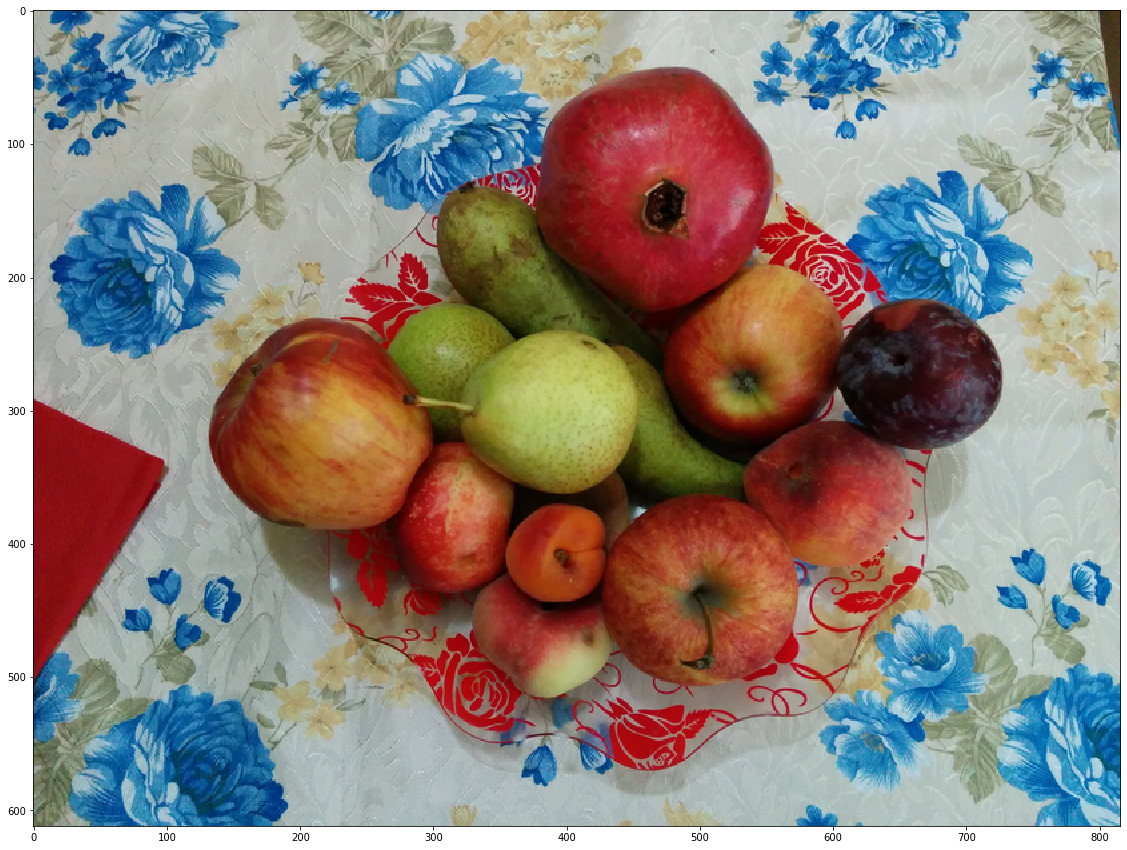

In [35]:
# By Heiko Gorski, Source: https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg
image_url = "file:\\C:\\Users\\Bommi\\Desktop\\Tensorflow\\testimage.jpg"  #@param
downloaded_image_path = download_and_resize_image(image_url, 816, 612, True)

In [8]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [9]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [45]:
def run_detector(detector, path):
    img = load_img(path)

    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    result = {key:value.numpy() for key,value in result.items()}

    print("Found %d objects." % len(result["detection_scores"]))
    print("Inference time: ", end_time-start_time)

    
    image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

    display_image(image_with_boxes)

Found 100 objects.
Inference time:  102.67459774017334
Font not found, using default font.


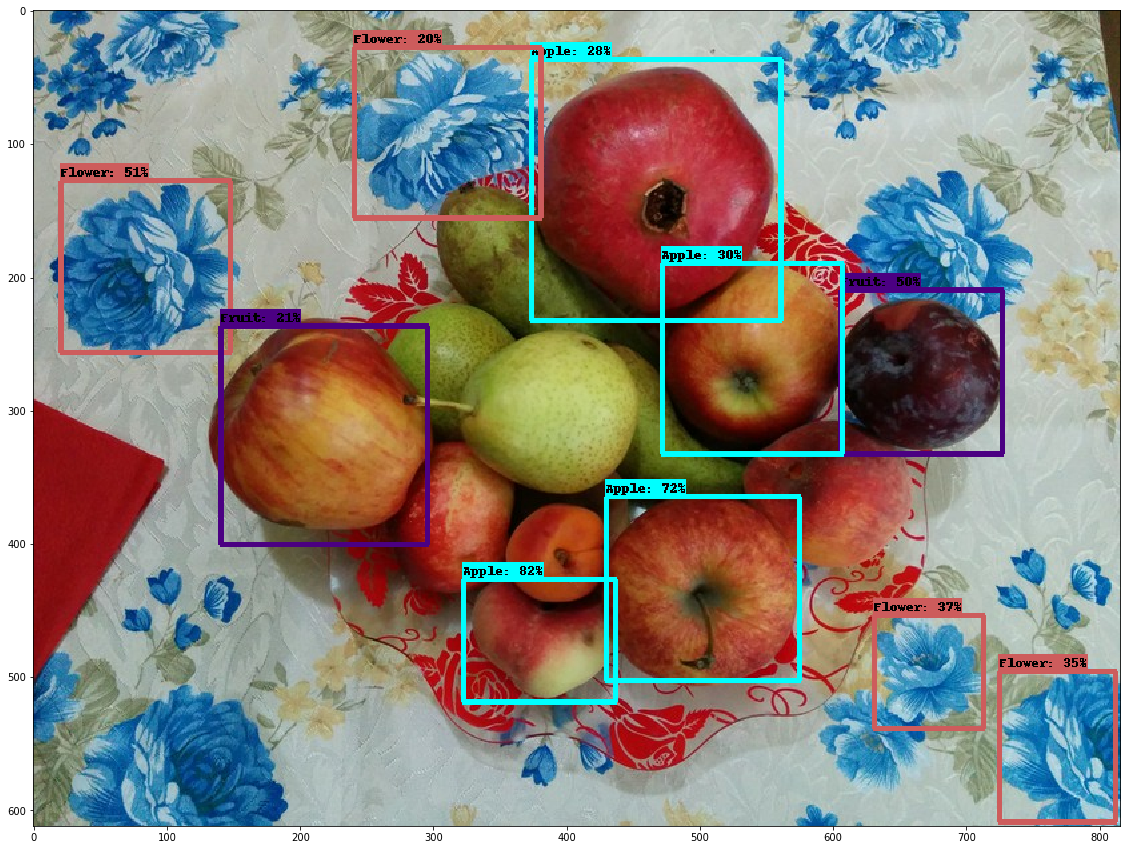

In [46]:
run_detector(detector, downloaded_image_path)

Found 100 objects.
Inference time:  79.8990375995636
Font not found, using default font.


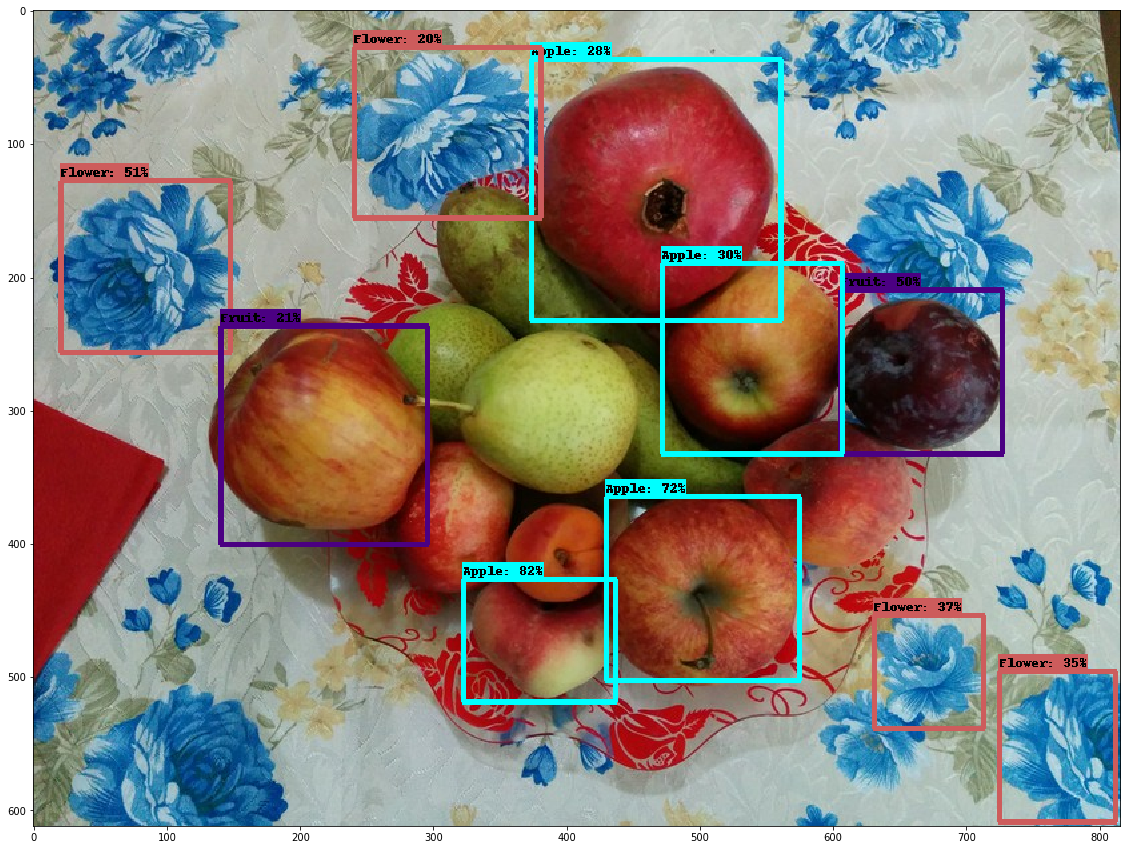

In [72]:
img = load_img(downloaded_image_path)

converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
start_time = time.time()
result = detector(converted_img)
end_time = time.time()

result = {key:value.numpy() for key,value in result.items()}

print("Found %d objects." % len(result["detection_scores"]))
print("Inference time: ", end_time-start_time)

    
image_with_boxes = draw_boxes(
img.numpy(), result["detection_boxes"],
result["detection_class_entities"], result["detection_scores"])

display_image(image_with_boxes)

In [73]:
type(result)

dict

In [76]:
l=('detection_class_entities','detection_scores')
i=1
for i in range(len(result['detection_class_entities'])):
    print({k:result[k][i] for k in l if k in result})

{'detection_class_entities': b'Apple', 'detection_scores': 0.8260584}
{'detection_class_entities': b'Apple', 'detection_scores': 0.72955704}
{'detection_class_entities': b'Flower', 'detection_scores': 0.5199092}
{'detection_class_entities': b'Fruit', 'detection_scores': 0.50979}
{'detection_class_entities': b'Flower', 'detection_scores': 0.37794763}
{'detection_class_entities': b'Flower', 'detection_scores': 0.3550301}
{'detection_class_entities': b'Apple', 'detection_scores': 0.30108768}
{'detection_class_entities': b'Apple', 'detection_scores': 0.2869468}
{'detection_class_entities': b'Fruit', 'detection_scores': 0.2133912}
{'detection_class_entities': b'Flower', 'detection_scores': 0.20451933}
{'detection_class_entities': b'Flower', 'detection_scores': 0.20076132}
{'detection_class_entities': b'Flower', 'detection_scores': 0.19108064}
{'detection_class_entities': b'Apple', 'detection_scores': 0.17397314}
{'detection_class_entities': b'Peach', 'detection_scores': 0.15915862}
{'detect

### More images
Perform inference on some additional images with time tracking.


In [ ]:
image_urls = [
  # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
  "https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg",
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg",
  # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
  "https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg",
  ]

def detect_img(image_url):
  start_time = time.time()
  image_path = download_and_resize_image(image_url, 640, 480)
  run_detector(detector, image_path)
  end_time = time.time()
  print("Inference time:",start_time-end_time)

In [ ]:
detect_img(image_urls[0])

In [ ]:
detect_img(image_urls[1])

In [ ]:
detect_img(image_urls[2])